# 使用回归方法，预测房产价格

这个工程中，将应用回归树、线性回归、xgboost回归等机器学习的方法，对房产的价格进行预测。
具体的步骤简述如下：

1. 载入并观察数据
2. categorical类型特征工程
3. numerical类特征工程
4. 处理异常值
5. 构造机器学习模型
6. 输入处理后数据，并交叉验证，选择最优模型
7. 按照evaluation规定，对模型的准确度进行评价

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline

## 载入数据集并观察

In [57]:
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')
print(df_train.columns)
df_train.head(5)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 数据集大小

In [58]:
# 1，样本量小；
# 2，训练集与测试集的数量基本相当
print("Training set size is %d"%df_train.shape[0])
print("Testing set size is %d"%df_test.shape[0])

Training set size is 1460
Testing set size is 1459


### 异常值情况

In [59]:
print('Count the na entries in each train set columns')
print(df_train.isnull().sum())
print('Count the na entries in each test set columns')
print(df_test.isnull().sum())

Count the na entries in each train set columns
Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQ

可看出：
1. 有些列存在严重的na情况；
2. 一些缺失的列存在强关联关系；
3. 有些列基本在所有样本中缺失。

### 训练集与测试集在异常值方面的不同

下述的特征，在训练集及测试集中存在不同的异常情况。在异常处理中，需要进行特殊的处理

In [60]:
train_index = df_train.iloc[:, :-1].isnull().sum()>0
test_index = df_test.isnull().sum()>0
diff = np.logical_xor(train_index, test_index)

diff_index = diff[diff==True].index
print(diff_index)

Index(['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageCars', 'GarageArea',
       'SaleType'],
      dtype='object')


## 特征选取

### 分辨categorical与numerical类型特征
对于categorical与numerical特征的分辨，主要目的在于之后对不同类型的特征使用不同的特征工程方法。

In [61]:
quantitative = []
qualitative = []

quantitative = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
quantitative.remove('Id')
quantitative.remove('SalePrice')
qualitative = [f for f in df_train.columns if df_train.dtypes[f] == 'object']

print('numerical features include:')
print(quantitative)
print('categorical features include:')
print(qualitative)

numerical features include:
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
categorical features include:
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQ

### categorical特征工程

这里说明一下，特征工程中，主要可分为两个步骤：
* 研究特征与label之间的关系，而这关系主要是由训练集中求得。
* 对特征数据进行处理，这部分工作就要对训练集及测试集同时进行。

下面对categorical类特征进行特征工程，主要步骤包括：
1. 使用boxplot直观理解关系；
2. anova方法研究具体关系；
3. 编码

这里分析一下所得的这些图。与上个文档中对于boxplot的使用方法类似，这里也是使用boxplot方法直观地研究categorical特征与回归值的关系。但本工程中对于特征值的着重点不同。具体来说： 1，这个工程中，主要注意的是图中，每个特征值对应的中值与其他特征值的变化情况。变化大，就说明该特征的不同取值对于回归值有影响；而在后边的anova分析中，也是用到了类似的概念； 2，该分析中并没有强调如第一个工程里，对于线性因素的挖掘。直观讲，这样也更加合理。因为categorical特征取值之间并没有数学意义，所以谈论线性也就无根据。

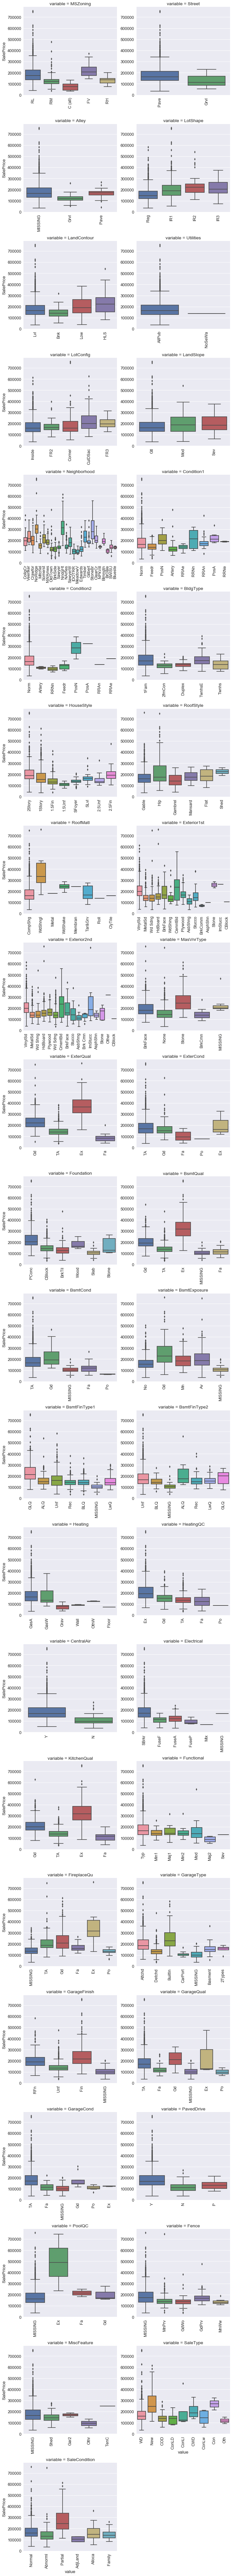

In [62]:
for f in qualitative:
    df_train[f] = df_train[f].astype('category')
    df_test[f] = df_test[f].astype('category')
    if df_train[f].isnull().any():
        df_train[f] = df_train[f].cat.add_categories(['MISSING'])
        df_train[f] = df_train[f].fillna('MISSING')
    if df_test[f].isnull().any():
        df_test[f] = df_test[f].cat.add_categories(['MISSING'])
        df_test[f] = df_test[f].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x = plt.xticks(rotation=90)
f = pd.melt(df_train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable", col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, 'value', 'SalePrice')

下面使用anova，即方差分析方法对categorical数据的统计特性进行分析。

这里要补充一下对于anova的知识。
anova中文翻译为：方差分析，具体的定义可以百度或者wiki。 在这里，使用anova主要是检验变量是否具有统计意义，或者说特征值的改变是否能够显著改变回归值。 f_oneway中，fval为得出的f值，而pval则是在F分布中，对应f值的概率。 当P>0.05时，我们就称特征不具备统计意义，或者说没有明显影响回归值。

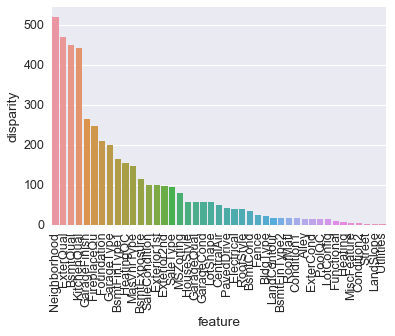

In [63]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c]==cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(df_train)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

#### categorical特征编码

In [64]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean']= frame[[feature,'SalePrice']].groupby(feature).mean()['SalePrice']
#     print(frame[[feature,'SalePrice']].groupby(feature).mean())
    ordering = ordering.sort_values('spmean')
    ordering['order'] = range(1, ordering.shape[0]+1)
#     print(ordering)
    ordering = ordering.order.to_dict()
#     print(ordering)
#     print('-------------------')
    
    for val, ord in ordering.items():
        frame.loc[frame[feature]==val, feature+'_E'] = ord
        
    return ordering

qual_encoded = []
train_ordering = {}
for q in qualitative:
    train_ordering[q] = encode(df_train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


In [65]:
# 测试集categorical特征编码

for index, di in train_ordering.items():
    for val, ord in di.items():
        df_test.loc[df_test[index]==val, index+'_E'] = ord
 
# 编码后，就可以将训练集及测试集中的categorical类型的变量删除
df_train.drop(qualitative, axis=1, inplace=True)
df_test.drop(qualitative, axis=1, inplace=True)
df_train.head(5)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,SaleType_E,SaleCondition_E
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,3.0,2.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,2.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0


### 相关性分析

在categorical特征转化为numerical特征后，就可以对整个特征空间的相关性进行分析了。
相关图能够定性地给出变量间的相关关系，实现特征筛选的第一次快速迭代。

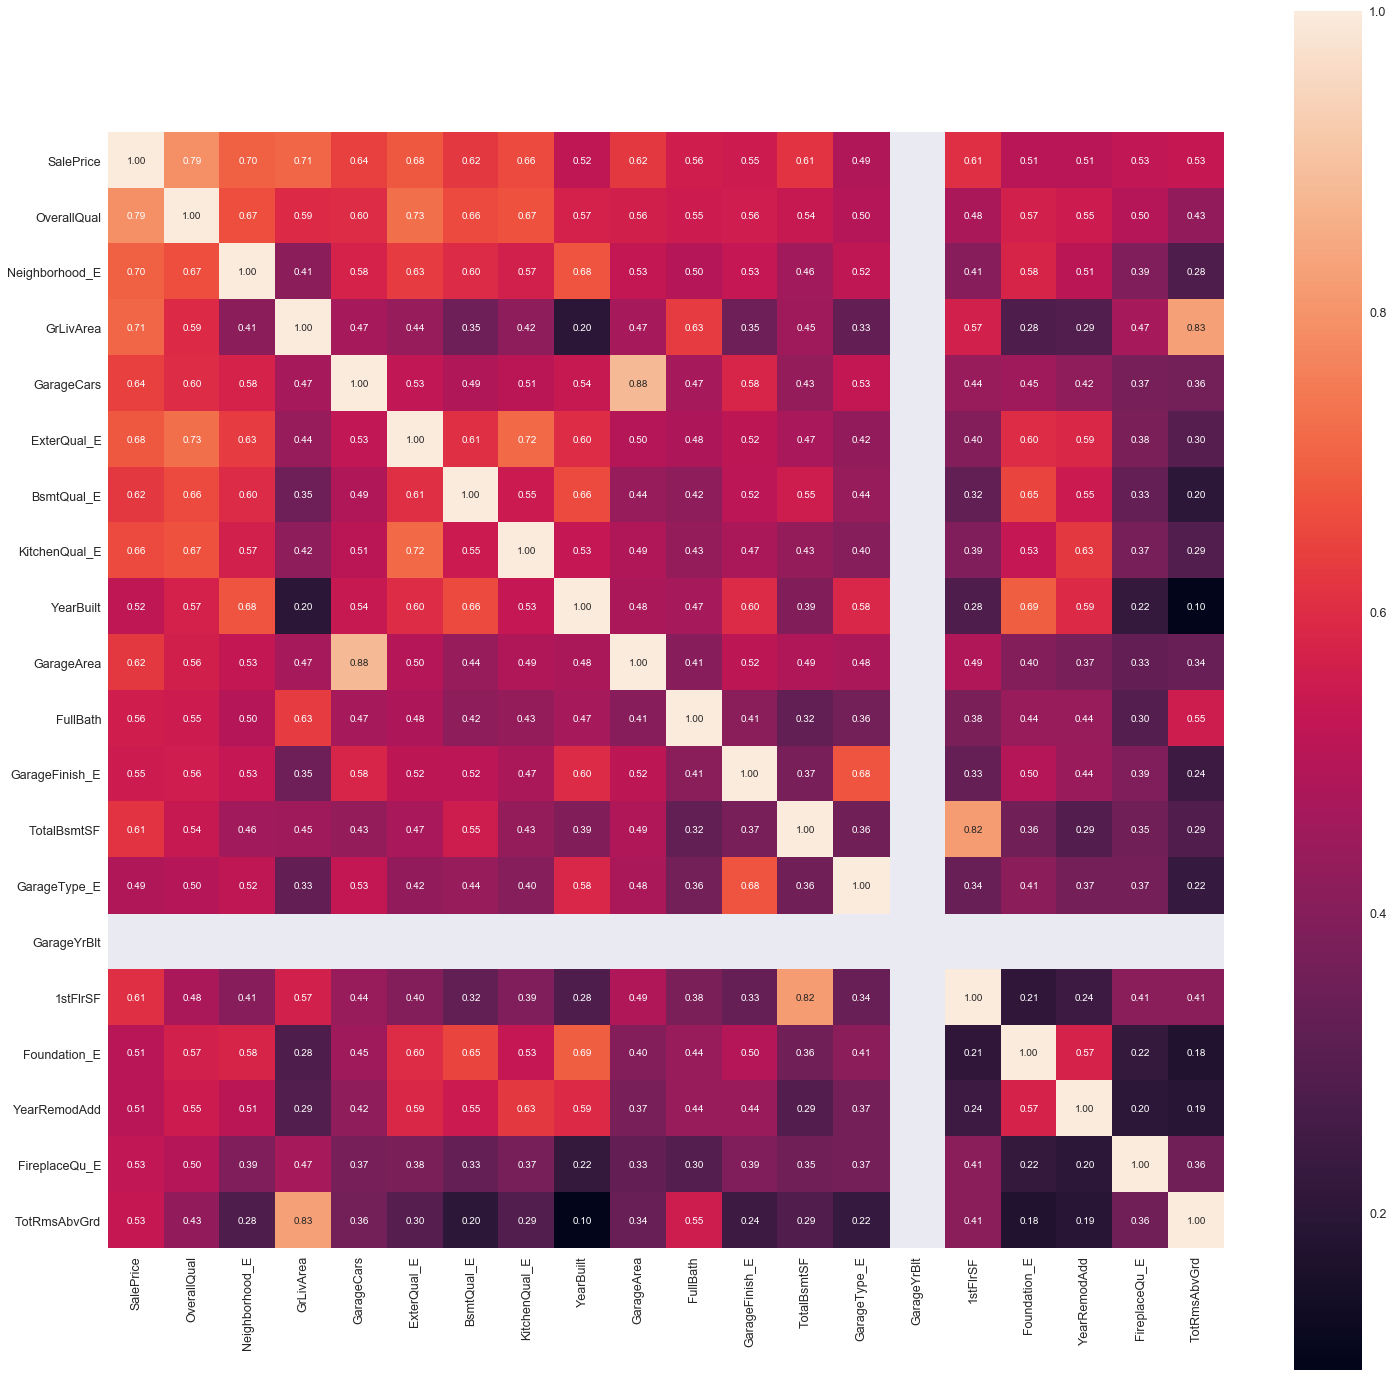

In [66]:
corrmat = df_train.corr(method='spearman')
k = 20
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(25,25))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [67]:
k = 20
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
print(cols)

Index(['SalePrice', 'OverallQual', 'Neighborhood_E', 'GrLivArea', 'GarageCars',
       'ExterQual_E', 'BsmtQual_E', 'KitchenQual_E', 'YearBuilt', 'GarageArea',
       'FullBath', 'GarageFinish_E', 'TotalBsmtSF', 'GarageType_E',
       'GarageYrBlt', '1stFlrSF', 'Foundation_E', 'YearRemodAdd',
       'FireplaceQu_E', 'TotRmsAbvGrd'],
      dtype='object')


## 缺失值及异常值处理

In [68]:
abn_f_train = [feature for feature in df_train.columns if df_train[feature].isnull().sum()>0]
abn_f_test = [feature for feature in df_test.columns if df_test[feature].isnull().sum()>0]
print(abn_f_train)
print('`````````')
print(abn_f_test)

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
`````````
['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'MSZoning_E', 'Utilities_E', 'Exterior1st_E', 'Exterior2nd_E', 'KitchenQual_E', 'Functional_E', 'SaleType_E']


In [69]:
fs = [f for f in abn_f_test if f not in abn_f_train]
print(df_test[fs].isnull().sum())

BsmtFinSF1       1
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
BsmtFullBath     2
BsmtHalfBath     2
GarageCars       1
GarageArea       1
MSZoning_E       4
Utilities_E      2
Exterior1st_E    1
Exterior2nd_E    1
KitchenQual_E    1
Functional_E     2
SaleType_E       1
dtype: int64


In [70]:
df_test.loc[df_test['GarageCars'].isnull(), 'GarageCars'] = 0
df_test.loc[df_test['GarageArea'].isnull(), 'GarageArea'] = 0

In [71]:
print(df_test.loc[df_test['BsmtFinSF1'].isnull()].index)
print(df_test.loc[df_test['BsmtFinSF1'].isnull()].index)
print(df_test.loc[df_test['BsmtUnfSF'].isnull()].index)
print(df_test.loc[df_test['TotalBsmtSF'].isnull()].index)
print('``````')
print(df_test.loc[df_test['BsmtFullBath'].isnull()].index)
print('``````')
print(df_test.loc[df_test['BsmtHalfBath'].isnull()].index)
print('``````')
print(df_test.loc[df_test['Exterior1st_E'].isnull()].index)
print(df_test.loc[df_test['Exterior2nd_E'].isnull()].index)
print(df_test.loc[df_test['Exterior2nd_E'].isnull()].index)
print('``````')
print(df_test.loc[df_test['KitchenQual_E'].isnull()].index)
print(df_test.loc[df_test['Functional_E'].isnull()].index)
print(df_test.loc[df_test['SaleType_E'].isnull()].index)

Int64Index([660], dtype='int64')
Int64Index([660], dtype='int64')
Int64Index([660], dtype='int64')
Int64Index([660], dtype='int64')
``````
Int64Index([660, 728], dtype='int64')
``````
Int64Index([660, 728], dtype='int64')
``````
Int64Index([691], dtype='int64')
Int64Index([691], dtype='int64')
Int64Index([691], dtype='int64')
``````
Int64Index([95], dtype='int64')
Int64Index([756, 1013], dtype='int64')
Int64Index([1029], dtype='int64')


In [72]:
print(train_ordering)

{'MSZoning': {'C (all)': 1, 'RM': 2, 'RH': 3, 'RL': 4, 'FV': 5}, 'Street': {'Grvl': 1, 'Pave': 2}, 'Alley': {'Grvl': 1, 'Pave': 2, 'MISSING': 3}, 'LotShape': {'Reg': 1, 'IR1': 2, 'IR3': 3, 'IR2': 4}, 'LandContour': {'Bnk': 1, 'Lvl': 2, 'Low': 3, 'HLS': 4}, 'Utilities': {'NoSeWa': 1, 'AllPub': 2}, 'LotConfig': {'Inside': 1, 'FR2': 2, 'Corner': 3, 'FR3': 4, 'CulDSac': 5}, 'LandSlope': {'Gtl': 1, 'Mod': 2, 'Sev': 3}, 'Neighborhood': {'MeadowV': 1, 'IDOTRR': 2, 'BrDale': 3, 'BrkSide': 4, 'Edwards': 5, 'OldTown': 6, 'Sawyer': 7, 'Blueste': 8, 'SWISU': 9, 'NPkVill': 10, 'NAmes': 11, 'Mitchel': 12, 'SawyerW': 13, 'NWAmes': 14, 'Gilbert': 15, 'Blmngtn': 16, 'CollgCr': 17, 'Crawfor': 18, 'ClearCr': 19, 'Somerst': 20, 'Veenker': 21, 'Timber': 22, 'StoneBr': 23, 'NridgHt': 24, 'NoRidge': 25}, 'Condition1': {'Artery': 1, 'RRAe': 2, 'Feedr': 3, 'RRAn': 4, 'Norm': 5, 'RRNe': 6, 'RRNn': 7, 'PosN': 8, 'PosA': 9}, 'Condition2': {'RRNn': 1, 'Artery': 2, 'Feedr': 3, 'RRAn': 4, 'Norm': 5, 'RRAe': 6, 'PosN

In [73]:
df_test.loc[df_test['BsmtFinSF1'].isnull(), 'BsmtFinSF1'] = 0
df_test.loc[df_test['BsmtFinSF2'].isnull(), 'BsmtFinSF2'] = 0
df_test.loc[df_test['BsmtUnfSF'].isnull(), 'BsmtUnfSF'] = 0
df_test.loc[df_test['TotalBsmtSF'].isnull(), 'TotalBsmtSF'] = 0

In [74]:
df_test.loc[df_test['BsmtFullBath'].isnull(), 'BsmtFullBath'] = 0
df_test.loc[df_test['BsmtHalfBath'].isnull(), 'BsmtHalfBath'] = 0

In [75]:
KQ_dis = df_test[df_test['ExterQual_E']==2]
KQ_dis.KitchenQual_E.describe()

count    891.000000
mean       2.162738
std        0.468566
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: KitchenQual_E, dtype: float64

In [76]:
df_test.loc[df_test['KitchenQual_E'].isnull(), 'KitchenQual_E'] = 2

In [77]:
df_test.loc[df_test['MSZoning_E'].isnull(), 'MSZoning_E'] = df_test['MSZoning_E'].value_counts().idxmax()
df_test.loc[df_test['Utilities_E'].isnull(), 'Utilities_E'] = df_test['Utilities_E'].value_counts().idxmax()
df_test.loc[df_test['Exterior1st_E'].isnull(), 'Exterior1st_E'] = df_test['Exterior1st_E'].value_counts().idxmax()
df_test.loc[df_test['Exterior2nd_E'].isnull(), 'Exterior2nd_E'] = df_test['Exterior2nd_E'].value_counts().idxmax()
df_test.loc[df_test['Functional_E'].isnull(), 'Functional_E'] = df_test['Functional_E'].value_counts().idxmax()
df_test.loc[df_test['SaleType_E'].isnull(), 'SaleType_E'] = df_test['SaleType_E'].value_counts().idxmax()

In [78]:
fs = [f for f in abn_f_test if f in abn_f_train]
print(df_train[fs].isnull().sum())
print('```````')
print(df_test[fs].isnull().sum())

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64
```````
LotFrontage    227
MasVnrArea      15
GarageYrBlt     78
dtype: int64


In [79]:
print(df_train.loc[df_train['MasVnrArea'].isnull(), 'MasVnrType_E'])
print(train_ordering['MasVnrType'])

234     4.0
529     4.0
650     4.0
936     4.0
973     4.0
977     4.0
1243    4.0
1278    4.0
Name: MasVnrType_E, dtype: float64
{'BrkCmn': 1, 'None': 2, 'BrkFace': 3, 'MISSING': 4, 'Stone': 5}


In [80]:
df_test.loc[df_test['MasVnrArea'].isnull(), 'MasVnrArea'] = 0
df_train.loc[df_train['MasVnrArea'].isnull(), 'MasVnrArea'] = 0

In [81]:
print(df_train.loc[df_train['GarageYrBlt'].isnull(), 'GarageFinish_E'])
print(train_ordering['GarageFinish'])

39      1.0
48      1.0
78      1.0
88      1.0
89      1.0
99      1.0
108     1.0
125     1.0
127     1.0
140     1.0
148     1.0
155     1.0
163     1.0
165     1.0
198     1.0
210     1.0
241     1.0
250     1.0
287     1.0
291     1.0
307     1.0
375     1.0
386     1.0
393     1.0
431     1.0
434     1.0
441     1.0
464     1.0
495     1.0
520     1.0
       ... 
954     1.0
960     1.0
968     1.0
970     1.0
976     1.0
1009    1.0
1011    1.0
1030    1.0
1038    1.0
1096    1.0
1123    1.0
1131    1.0
1137    1.0
1143    1.0
1173    1.0
1179    1.0
1218    1.0
1219    1.0
1234    1.0
1257    1.0
1283    1.0
1323    1.0
1325    1.0
1326    1.0
1337    1.0
1349    1.0
1407    1.0
1449    1.0
1450    1.0
1453    1.0
Name: GarageFinish_E, Length: 81, dtype: float64
{'MISSING': 1, 'Unf': 2, 'RFn': 3, 'Fin': 4}


In [82]:
df_train.loc[df_train['GarageYrBlt'].isnull(), 'GarageYrBlt'] = 0
df_test.loc[df_test['GarageYrBlt'].isnull(), 'GarageYrBlt'] = 0

In [83]:
print(df_train.loc[df_train['LotFrontage'].isnull(), 'Street_E'])
print(train_ordering['Street'])
print(df_train.loc[df_train['Street_E']==2.0, 'LotFrontage'])

7       2.0
12      2.0
14      2.0
16      2.0
24      2.0
31      2.0
42      2.0
43      2.0
50      2.0
64      2.0
66      2.0
76      2.0
84      2.0
95      2.0
100     2.0
104     2.0
111     2.0
113     2.0
116     2.0
120     2.0
126     2.0
131     2.0
133     2.0
136     2.0
147     2.0
149     2.0
152     2.0
153     2.0
160     2.0
166     2.0
       ... 
1300    2.0
1301    2.0
1309    2.0
1312    2.0
1318    2.0
1321    2.0
1342    2.0
1346    2.0
1348    2.0
1354    2.0
1356    2.0
1357    2.0
1358    2.0
1362    2.0
1365    2.0
1368    2.0
1373    2.0
1381    2.0
1383    2.0
1396    2.0
1407    2.0
1417    2.0
1419    2.0
1423    2.0
1424    2.0
1429    2.0
1431    2.0
1441    2.0
1443    2.0
1446    2.0
Name: Street_E, Length: 259, dtype: float64
{'Grvl': 1, 'Pave': 2}
0        65.0
1        80.0
2        68.0
3        60.0
4        84.0
5        85.0
6        75.0
7         NaN
8        51.0
9        50.0
10       70.0
11       85.0
12        NaN
13       91.0
14   

In [84]:
df_train.loc[df_train['LotFrontage'].isnull(), 'LotFrontage'] = np.mean(df_train.loc[df_train['Street_E']==2.0, 'LotFrontage'])
df_test.loc[df_test['LotFrontage'].isnull(), 'LotFrontage'] = np.mean(df_test.loc[df_test['Street_E']==2.0, 'LotFrontage'])

In [85]:
print(np.sum(df_train.isnull()))
print('``````')
print(np.sum(df_test.isnull()))

Id                 0
MSSubClass         0
LotFrontage        0
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         0
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt        0
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
                  ..
RoofStyle_E        0
RoofMatl_E         0
Exterior1st_E      0
Exterior2nd_E      0
MasVnrType_E       0
ExterQual_E        0
ExterCond_E        0
Foundation_E       0
BsmtQual_E         0
BsmtCond_E         0
BsmtExposure_E     0
BsmtFinType1_E     0
BsmtFinType2_E     0
Heating_E          0
HeatingQC_E        0
CentralAir_E       0
Electrical_E 

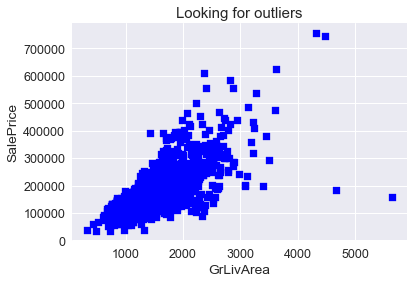

In [86]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(df_train.GrLivArea, df_train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

df_train = df_train[df_train.GrLivArea < 4000]

In [87]:
df_train.replace([-np.inf],0)
df_test.replace([-np.inf],0)
df_train.replace([np.nan],0)
df_test.replace([np.nan],0)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,SaleType_E,SaleCondition_E
0,1461,20,80.000000,11622,5,6,1961,1961,0.0,468.0,...,6.0,2.0,4.0,6.0,3.0,1.0,3.0,4.0,5.0,5.0
1,1462,20,81.000000,14267,6,6,1958,1958,108.0,923.0,...,6.0,2.0,4.0,6.0,3.0,1.0,5.0,3.0,5.0,5.0
2,1463,60,74.000000,13830,5,5,1997,1998,0.0,791.0,...,6.0,4.0,4.0,6.0,3.0,1.0,3.0,4.0,5.0,5.0
3,1464,60,78.000000,9978,6,6,1998,1998,20.0,602.0,...,6.0,4.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
4,1465,120,43.000000,5005,8,5,1992,1992,0.0,263.0,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
5,1466,60,75.000000,10000,6,5,1993,1994,0.0,0.0,...,6.0,4.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
6,1467,20,68.488998,7980,6,7,1992,2007,0.0,935.0,...,6.0,4.0,4.0,6.0,3.0,1.0,4.0,2.0,5.0,5.0
7,1468,60,63.000000,8402,6,5,1998,1998,0.0,0.0,...,6.0,4.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
8,1469,20,85.000000,10176,7,5,1990,1990,0.0,637.0,...,6.0,2.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
9,1470,20,70.000000,8400,4,5,1970,1970,0.0,804.0,...,6.0,4.0,4.0,6.0,3.0,1.0,3.0,4.0,5.0,5.0


## Numerical特征工程

### 正态性

In [88]:
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

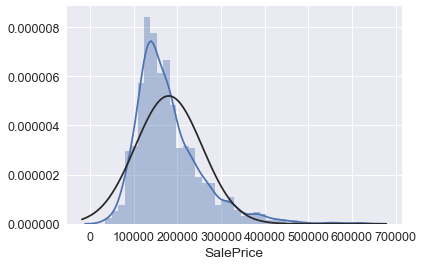

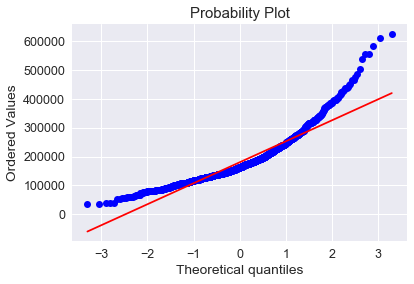

In [89]:
sns.distplot(df_train['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [90]:
df_train.SalePrice = np.log1p(df_train.SalePrice)

In [91]:
skewness = df_train[quantitative].apply(lambda x: stats.skew(x))
skewness = skewness[skewness > 0.5]
feature_skewed = skewness.index
df_train[feature_skewed] = np.log1p(df_train[feature_skewed])
print('%d features changed'%feature_skewed.shape[0])

25 features changed


In [92]:
df_test[feature_skewed] = np.log1p(df_test[feature_skewed])
print('%d features changed'%feature_skewed.shape[0])

25 features changed


## 生成新特征

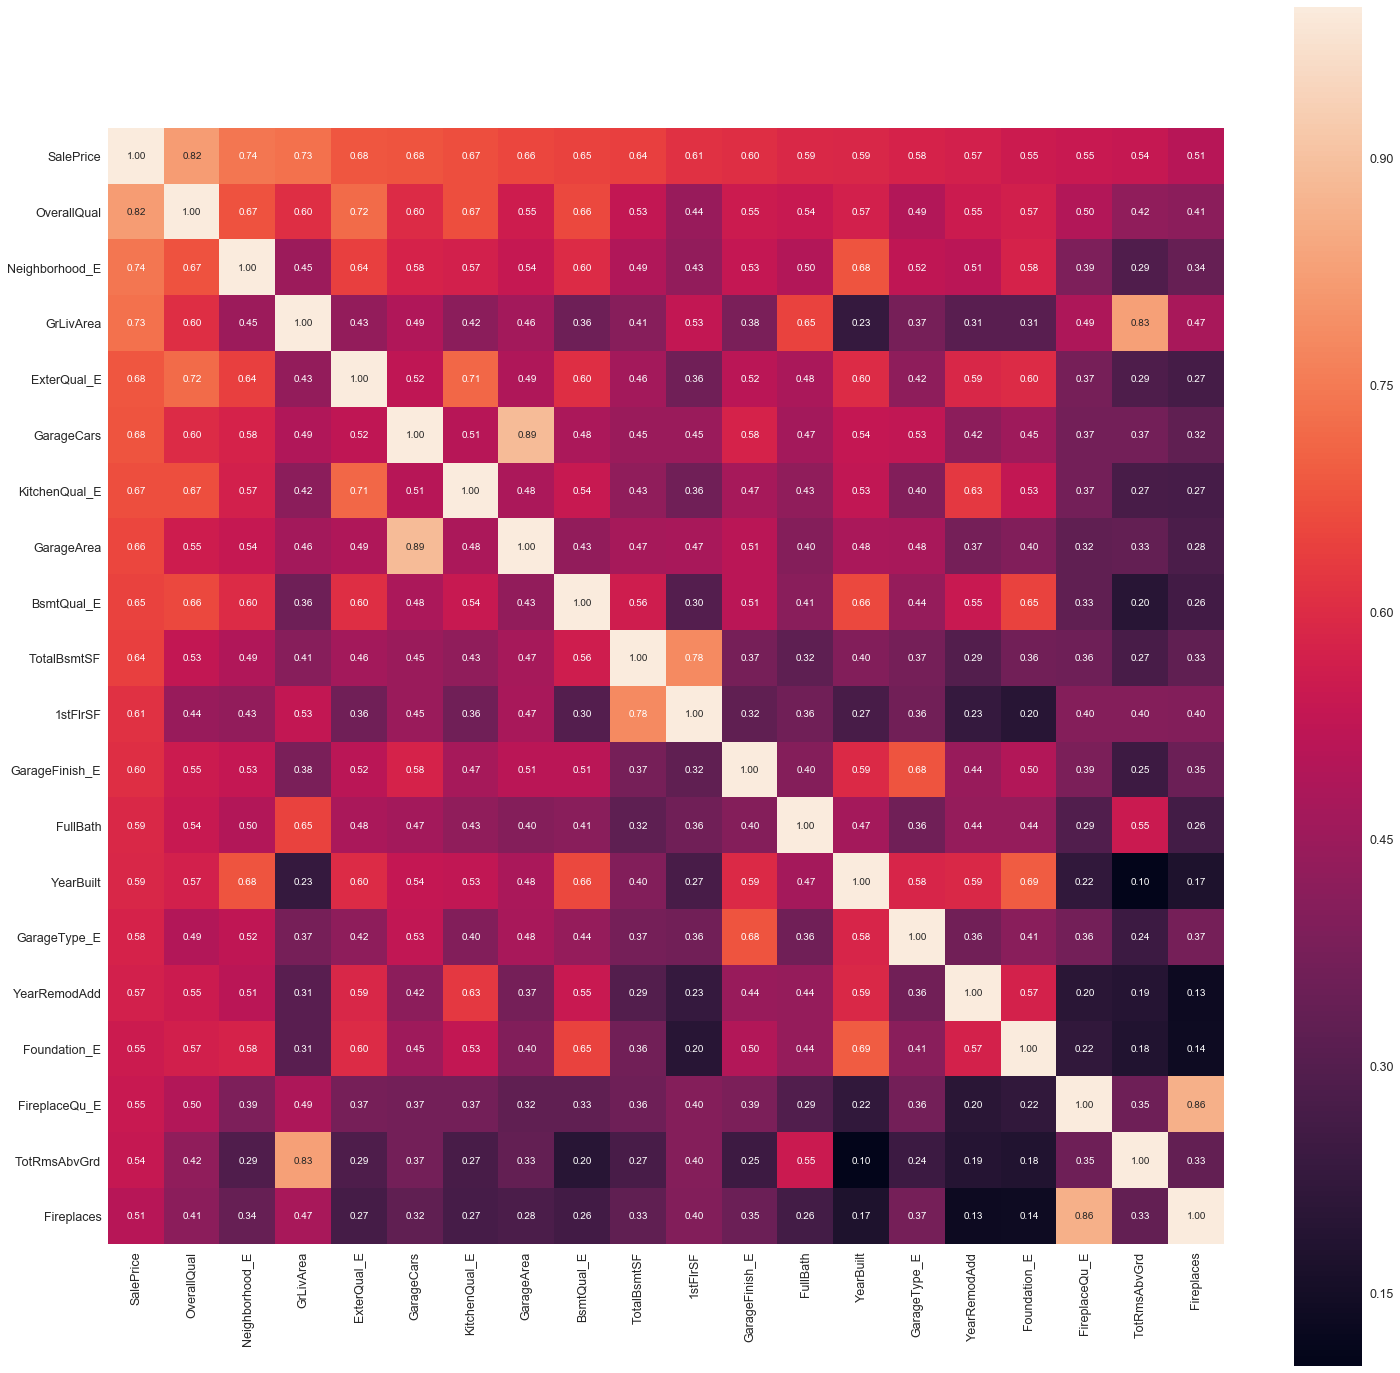

In [93]:
corrmat = df_train.corr()
k = 20
cols = np.abs(corrmat).nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(25,25))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [94]:
cols = cols.drop('SalePrice')
for col in cols:
    df_train[col+'sqrt'] = np.sqrt(df_train[col])
    df_train[col+'2'] = df_train[col]**2
    df_train[col+'3'] = df_train[col]**3
    df_test[col+'sqrt'] = np.sqrt(df_test[col])
    df_test[col+'2'] = df_test[col]**2
    df_test[col+'3'] = df_test[col]**3

df_train.head(10)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,Foundation_E3,FireplaceQu_Esqrt,FireplaceQu_E2,FireplaceQu_E3,TotRmsAbvGrdsqrt,TotRmsAbvGrd2,TotRmsAbvGrd3,Fireplacessqrt,Fireplaces2,Fireplaces3
0,1,4.110874,4.189655,9.042040,7,1.791759,2003,2003,5.283204,6.561031,...,216.0,1.414214,4.0,8.0,1.482304,4.827796,10.607752,0.000000,0.000000,0.000000
1,2,3.044522,4.394449,9.169623,6,2.197225,1976,1976,0.000000,6.886532,...,27.0,2.000000,16.0,64.0,1.394959,3.786566,7.368318,0.832555,0.480453,0.333025
2,3,4.110874,4.234107,9.328212,7,1.791759,2001,2002,5.093750,6.188264,...,216.0,2.000000,16.0,64.0,1.394959,3.786566,7.368318,0.832555,0.480453,0.333025
3,4,4.262680,4.110874,9.164401,7,1.791759,1915,1970,0.000000,5.379897,...,8.0,2.236068,25.0,125.0,1.442027,4.324077,8.991666,0.832555,0.480453,0.333025
4,5,4.110874,4.442651,9.565284,8,1.791759,2000,2000,5.860786,6.486161,...,216.0,2.000000,16.0,64.0,1.517427,5.301898,12.208072,0.832555,0.480453,0.333025
5,6,3.931826,4.454347,9.555064,5,1.791759,1993,1995,0.000000,6.597146,...,125.0,1.414214,4.0,8.0,1.338566,3.210402,5.752268,0.000000,0.000000,0.000000
6,7,3.044522,4.330733,9.218804,8,1.791759,2004,2005,5.231109,7.222566,...,216.0,2.236068,25.0,125.0,1.442027,4.324077,8.991666,0.832555,0.480453,0.333025
7,8,4.110874,4.262480,9.247925,7,1.945910,1973,1973,5.484797,6.756932,...,27.0,2.000000,16.0,64.0,1.442027,4.324077,8.991666,1.048147,1.206949,1.325969
8,9,3.931826,3.951244,8.719481,7,1.791759,1931,1950,0.000000,0.000000,...,8.0,2.000000,16.0,64.0,1.482304,4.827796,10.607752,1.048147,1.206949,1.325969
9,10,5.252273,3.931826,8.912069,5,1.945910,1939,1950,0.000000,6.747587,...,8.0,2.000000,16.0,64.0,1.338566,3.210402,5.752268,1.048147,1.206949,1.325969


In [95]:
print(df_train.shape)
print('```````')
print(df_test.shape)

(1456, 138)
```````
(1459, 137)


## 构造输入至模型中的训练集测试集。

In [96]:
features = df_train.columns.drop(['SalePrice','Id'])
X_train = df_train[features]
y_train = df_train['SalePrice']
X_test = df_test[features]

In [97]:
miss_data = pd.DataFrame({'amount': X_train.isnull().sum(), 'ratio':X_train.isnull().sum() / X_train.shape[0]})
print(miss_data)

                    amount  ratio
MSSubClass               0    0.0
LotFrontage              0    0.0
LotArea                  0    0.0
OverallQual              0    0.0
OverallCond              0    0.0
YearBuilt                0    0.0
YearRemodAdd             0    0.0
MasVnrArea               0    0.0
BsmtFinSF1               0    0.0
BsmtFinSF2               0    0.0
BsmtUnfSF                0    0.0
TotalBsmtSF              0    0.0
1stFlrSF                 0    0.0
2ndFlrSF                 0    0.0
LowQualFinSF             0    0.0
GrLivArea                0    0.0
BsmtFullBath             0    0.0
BsmtHalfBath             0    0.0
FullBath                 0    0.0
HalfBath                 0    0.0
BedroomAbvGr             0    0.0
KitchenAbvGr             0    0.0
TotRmsAbvGrd             0    0.0
Fireplaces               0    0.0
GarageYrBlt              0    0.0
GarageCars               0    0.0
GarageArea               0    0.0
WoodDeckSF               0    0.0
OpenPorchSF   

In [98]:
miss_data = pd.DataFrame({'amount': X_test.isnull().sum(), 'ratio':X_test.isnull().sum() / X_test.shape[0]})
print(miss_data)

                    amount  ratio
MSSubClass               0    0.0
LotFrontage              0    0.0
LotArea                  0    0.0
OverallQual              0    0.0
OverallCond              0    0.0
YearBuilt                0    0.0
YearRemodAdd             0    0.0
MasVnrArea               0    0.0
BsmtFinSF1               0    0.0
BsmtFinSF2               0    0.0
BsmtUnfSF                0    0.0
TotalBsmtSF              0    0.0
1stFlrSF                 0    0.0
2ndFlrSF                 0    0.0
LowQualFinSF             0    0.0
GrLivArea                0    0.0
BsmtFullBath             0    0.0
BsmtHalfBath             0    0.0
FullBath                 0    0.0
HalfBath                 0    0.0
BedroomAbvGr             0    0.0
KitchenAbvGr             0    0.0
TotRmsAbvGrd             0    0.0
Fireplaces               0    0.0
GarageYrBlt              0    0.0
GarageCars               0    0.0
GarageArea               0    0.0
WoodDeckSF               0    0.0
OpenPorchSF   

## 构建模型

In [112]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import (RandomForestRegressor, 
                              AdaBoostRegressor, 
                              GradientBoostingRegressor, 
                              ExtraTreesRegressor)
from sklearn.svm import SVR
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error

In [111]:
X = X_train.values
y = y_train.values
X_t = X_test.values

# print(X_train)
# print('---------------')
# print(X_train.values)
# print(X.shape)
# print(X_t.shape)

### RidgeCV

In [113]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X, y)
alpha = ridge.alpha_
print(alpha)

# print("Try again for more precision with alphas centered around " + str(alpha))
# ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
#                           alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
#                           alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
#                 cv = 10)
# ridge.fit(X_train, y)
# alpha = ridge.alpha_
# print("Best alpha :", alpha)

# 以上计算得alpha值为1.4，切好是可选alphas参数的边界值，故可能此范围太窄，可以考虑扩大范围

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = alpha*range(50,200)*0.01, cv = 10)
ridge.fit(X, y)
alpha = ridge.alpha_
print("Best alpha :", alpha)

#放大范围后，最优alpha值为0.63

1.0
Try again for more precision with alphas centered around 1.0
Best alpha : 1.63


In [119]:
ridge_train_out = ridge.predict(X)
ridge_test_out = ridge.predict(X_t)
print("RMSE of RidgeCV %f"
       %np.sqrt(mean_squared_error(y_true=y, y_pred=ridge_train_out)))

# save data
result = pd.DataFrame()
result['Id'] = df_test['Id']
result['SalePrice'] = np.exp(ridge_test_out)
result.to_csv('ridge_result.csv',index=False)

RMSE of RidgeCV 0.102076


### LassoCV

In [128]:
# max_iter 默认为1000，由于alpha值较小，出现不收敛的警告
lass = LassoCV(alphas = [0.0001, 0.0003, 0.001, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
lass.fit(X, y)
alpha = lass.alpha_
print(alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lass = LassoCV(alphas = alpha*range(10,150)*0.01, cv = 10)
lass.fit(X, y)
alpha = lass.alpha_
print("Best alpha :", alpha)

# 放大alpha范围后，最优值由0.0006变为0.00028

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.0003
Try again for more precision with alphas centered around 0.0003
Best alpha : 0.000276


C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [58]:
lass_train_out = lass.predict(X)
lass_test_out = lass.predict(X_t)
print("RMSE of LassoCV regressor %f"
       %np.sqrt(mean_squared_error(y_true=y, y_pred=lass_train_out)))

# save data
result = pd.DataFrame()
result['Id'] = df_test['Id']
result['SalePrice'] = np.exp(lass_test_out)
result.to_csv('lass_result.csv',index=False)

RMSE of xgb regressor 0.104709


### ElasticNetCV

In [129]:
en = ElasticNetCV(alphas = [0.0001, 0.0003, 0.001, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
en.fit(X_train, y)
alpha = en.alpha_
print(alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
en = ElasticNetCV(alphas = alpha*range(10,150)*0.01, cv = 10)
en.fit(X_train, y)
alpha = en.alpha_
print("Best alpha :", alpha)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.001
Try again for more precision with alphas centered around 0.001
Best alpha : 0.00055


C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [130]:
en_train_out = en.predict(X)
en_test_out = en.predict(X_t)
print("RMSE of ElasticNetCV regressor %f"
       %np.sqrt(mean_squared_error(y_true=y, y_pred=en_train_out)))

result = pd.DataFrame()
result['Id'] = df_test['Id']
result['SalePrice'] = np.exp(en_test_out)
result.to_csv('en_result.csv',index=False)

RMSE of ElasticNetCV regressor 0.103672


### XGBoost

In [132]:
import xgboost as xgb

err_lowest = np.inf
estm_list = [1000, 2000, 500]
lr_list = [0.01, 0.05, 0.075]
for lr in lr_list:
    for estm in estm_list:
        params = {
            'learning_rate':lr,
            'n_estimators':estm,
            'max_depth':6,
            'min_child_weight':2,
            #gamma=1,
            'gamma':0.5,                        
            'subsample':0.4,
            'colsample_bytree':0.8,
            'objective': 'reg:linear',
            'nthread':-1,
            'scale_pos_weight':1
            }
    
        xgbm = SklearnRegressor(clf=xgb.XGBRegressor, params=params)
        err = cv_train(xgbm, X, y)
    
        if err < err_lowest:
            best_xgbm = xgbm
            err_lowest = err
            est_lowest = estm
            lr_lowest = lr

print(err_lowest)
print(est_lowest)
print(lr_lowest)

ModuleNotFoundError: No module named 'xgboost'

In [145]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

model = xgb.XGBRegressor()

params = {
            'learning_rate':[0.01, 0.05, 0.075],
            'n_estimators':[1000, 2000, 500],
            'max_depth':(6,),
            'min_child_weight':(2,),
            #gamma=1,
            'gamma':(0.5,),                        
            'subsample':(0.4,),
            'colsample_bytree':(0.8,),
            'objective': ('reg:linear',),
            'nthread':(-1,),
            'scale_pos_weight':(1,)
            }
# 使用GridSearchCV寻找最优参数
clf = GridSearchCV(model, params).fit(X,y)

xgb_train_out = clf.predict(X)
xgb_test_out = clf.predict(X_t)
print("RMSE of xgb regressor %f"
       %np.sqrt(mean_squared_error(y_true=y, y_pred=xgb_train_out)))

In [76]:
ens_input = pd.DataFrame({'ridge':ridge_train_out.ravel(),
                          'lass':lass_train_out.ravel(),
                          'en':en_train_out.ravel(),
                          'xgb':xgb_train_out.ravel(),
#                           'svr':svr_oof_train.ravel()
                         })

ens_test = pd.DataFrame({'ridge':ridge_test_out.ravel(),
                          'lass':lass_test_out.ravel(),
                          'en':en_test_out.ravel(),
                          'xgb':xgb_test_out.ravel(),
#                           'svr':svr_oof_test.ravel()
                        })

ens_input.head(5)

,en,lass,ridge,xgb
0,12.222958,12.223810,12.221089,12.251938
1,12.153189,12.154913,12.157967,12.050305
2,12.292913,12.295851,12.287189,12.308783
3,12.046110,12.046026,12.027813,12.151443
4,12.627696,12.627049,12.627771,12.635288


In [78]:
ens_EN = ElasticNetCV(alphas = [0.0001, 0.0003, 0.001, 0.003])
ens_EN.fit(ens_input, y)
alpha = ens_EN.alpha_
print(alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ens_EN = ElasticNetCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ens_EN.fit(ens_input, y)
alpha = ens_EN.alpha_
print("Best alpha :", alpha)

0.0001
Try again for more precision with alphas centered around 0.0001
Best alpha : 6e-05


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

In [79]:
ens_train_out = ens_ridge.predict(ens_input)
ens_test_out = ens_ridge.predict(ens_test)
print("RMSE of xgb regressor %f"
       %np.sqrt(mean_squared_error(y_true=y, y_pred=ens_train_out)))

RMSE of xgb regressor 0.100495


In [80]:
result = pd.DataFrame()
result['Id'] = df_test['Id']
result['SalePrice'] = np.exp(ens_test_out)
result.to_csv('ens_result.csv',index=False)

# 建立机器学习模型，进行训练

In [64]:
import xgboost as xgb
from sklearn.ensemble import (RandomForestRegressor, 
                              AdaBoostRegressor, 
                              GradientBoostingRegressor, 
                              ExtraTreesRegressor)
from sklearn.svm import SVR
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error

## 第一步，是建立具有统一接口的类

In [134]:
class SklearnRegressor(object):
    def __init__(self, clf,params=None):
        self.clf = clf(**params)
        
    def train(self, X, y):
        self.clf.fit(X, y)
    
    def predict(self, X):
        return self.clf.predict(X)
    
    def fit(self, X, y ):
        return self.clf.fit(X, y)

In [138]:
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(ntrain, n_folds=NFOLDS, random_state=SEED)

## 应用OOF方法，训练第一层模型

In [139]:
def oof_train(clf, X, y, X_test):
# def oof_train(clf, X, y):
    train_out = np.zeros((ntrain,))
    test_out = np.zeros((ntest,))
    oof_out = np.zeros((NFOLDS, ntest))
    
    for i, (train_index, val_index) in enumerate(kf):
        x_tr = X[train_index]
        y_tr = y[train_index]
        x_val = X[val_index]
        
        clf.train(x_tr, y_tr)
        
        train_out[val_index] = clf.predict(x_val)
        oof_out[i, :] = clf.predict(X_test)
    
    test_out = oof_out.mean(axis=0)
    return train_out.reshape(-1, 1), test_out.reshape(-1, 1)

## 初步设定模型参数

In [ ]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 5000,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0,
    'random_state' : SEED
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':5000,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0,
    'random_state' : SEED
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 2000,
    'learning_rate' : 0.75,
    'random_state' : SEED
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 2000,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0,
    'random_state' : SEED
}

# Support Vector Regressor parameters 
svr_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

按照预设参数，初始化模型

In [ ]:
rf = SklearnRegressor(clf=RandomForestRegressor, params=rf_params)
et = SklearnRegressor(clf=ExtraTreesRegressor, params=et_params)
ada = SklearnRegressor(clf=AdaBoostRegressor, params=ada_params)
gb = SklearnRegressor(clf=GradientBoostingRegressor, params=gb_params)
# svr = SklearnRegressor(clf=SVR, params=svr_params)

在这里，插入对于cross validation的使用。
使用参数较少的svr进行试验。

In [ ]:
X = X_train.values
y = y_train.values
X_t = X_test.values

print(X.shape)
print(X_t.shape)

In [136]:
def cv_train(clf, X, y):
    train_out = np.zeros((ntrain,))
    
    for i, (train_index, val_index) in enumerate(kf):
        x_tr = X[train_index]
        y_tr = y[train_index]
        x_val = X[val_index]
        
        clf.train(x_tr, y_tr)
        train_out[val_index] = clf.predict(x_val)
   
    error = np.sqrt(mean_squared_error(y_true=y, y_pred=train_out))
    return error

In [ ]:
c_list = [0.005, 0.01, 0.015, 0.02]
lowest_err = np.inf
for c in c_list:
    params = {
        'kernel': 'linear',
        'C': c
    }
    svr = SklearnRegressor(clf=SVR, params=params)
    err = cv_train(svr, X, y)
    
    if err < lowest_err:
        best_svr = svr
        lowest_err = err
        lowest_c = c

print(lowest_err)
print(lowest_c)

In [ ]:
# Random Forest parameters
# rf_params = {
#     'n_jobs': -1,
#     'n_estimators': 500,
#      'warm_start': True, 
#      #'max_features': 0.2,
#     'max_depth': 6,
#     'min_samples_leaf': 2,
#     'max_features' : 'sqrt',
#     'verbose': 0,
#     'random_state' : SEED
# }

estimators_list = [10, 50, 100, 150,200]
lowest_err = np.inf
for est in estimators_list:
    # Random Forest parameters
    params = {
        'n_jobs': -1,
        'n_estimators': est,
        'warm_start': True, 
        #'max_features': 0.2,
        'max_depth': 6,
        'min_samples_leaf': 2,
        'max_features' : 'sqrt',
        'verbose': 0,
        'random_state' : SEED
}
    rf = SklearnRegressor(clf=RandomForestRegressor, params=params)
    err = cv_train(rf, X, y)
    
    if err < lowest_err:
        best_rf = rf
        lowest_err = err
        lowest_est = est

print(lowest_err)
print(lowest_est)

In [ ]:
# Extra Trees Parameters
# et_params = {
#     'n_jobs': -1,
#     'n_estimators':500,
#     #'max_features': 0.5,
#     'max_depth': 8,
#     'min_samples_leaf': 2,
#     'verbose': 0,
#     'random_state' : SEED
# }

estimators_list = [170,200,250]
lowest_err = np.inf
for est in estimators_list:
    # Random Forest parameters
# Extra Trees Parameters
    params = {
    'n_jobs': -1,
    'n_estimators':est,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0,
    'random_state' : SEED
}
    et = SklearnRegressor(clf=ExtraTreesRegressor, params=params)
    err = cv_train(et, X, y)
    
    if err < lowest_err:
        best_et = et
        lowest_err = err
        lowest_est = est

print(lowest_err)
print(lowest_est)

In [ ]:
# AdaBoost parameters
# ada_params = {
#     'n_estimators': 500,
#     'learning_rate' : 0.75,
#     'random_state' : SEED
# }

lr_list = [0.08, 0.1, 0.15]
est_list = [80, 100, 150, 200]
lowest_err = np.inf
for lr in lr_list:
    for est in est_list:
        params = {
         'n_estimators': est,
         'learning_rate' : lr,
         'random_state' : SEED
        }
        
        ada = SklearnRegressor(clf=AdaBoostRegressor, params=params)
        err = cv_train(ada, X, y)
        
        if err < lowest_err:
            best_ada = ada
            lowest_err = err
            lowest_est = est
            lowest_lr = lr

print(lowest_err)
print(lowest_est)
print(lowest_lr)

In [ ]:
est_list = [10,30, 50,70]
lowest_err = np.inf
for est in est_list:
    params = {
    'n_estimators':est,
    #'max_features': 0.5,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0,
    'random_state' : SEED
}
    gb = SklearnRegressor(clf=GradientBoostingRegressor, params=params)
    err = cv_train(gb, X, y)
    
    if err < lowest_err:
        best_gb = gb
        lowest_err = err
        lowest_est = est

print(lowest_err)
print(lowest_est)

## 将输入数据转化为ndarray类型

In [ ]:
# et_oof_train, et_oof_test = oof_train(best_et, X, y, X_t)
# rf_oof_train, rf_oof_test = oof_train(best_rf, X, y, X_t)
# ada_oof_train, ada_oof_test = oof_train(best_ada, X, y, X_t)
# gb_oof_train, gb_oof_test = oof_train(best_gb, X, y, X_t)
# svr_oof_train, svr_oof_test = oof_train(best_svr, X, y, X_t)

et_oof_train, et_oof_test = oof_train(et, X, y, X_t)
rf_oof_train, rf_oof_test = oof_train(rf, X, y, X_t)
ada_oof_train, ada_oof_test = oof_train(ada, X, y, X_t)
gb_oof_train, gb_oof_test = oof_train(gb, X, y, X_t)
# svr_oof_train, svr_oof_test = oof_train(svr, X, y, X_t)
print('Training is completed!')

In [ ]:
print("RMSE of et regressor %f"
       %np.sqrt(mean_squared_error(y_true=y, y_pred=et_oof_train)))
print("RMSE of rf regressor %f"
       %np.sqrt(mean_squared_error(y_true=y, y_pred=rf_oof_train)))
print("RMSE of ada regressor %f"
       %np.sqrt(mean_squared_error(y_true=y, y_pred=ada_oof_train)))
print("RMSE of gb regressor %f"
       %np.sqrt(mean_squared_error(y_true=y, y_pred=gb_oof_train)))
# print("RMSE of svr regressor %f"
#        %np.sqrt(mean_squared_error(y_true=y, y_pred=svr_oof_train)))

In [ ]:
xgb_input = pd.DataFrame({'rf':rf_oof_train.ravel(),
                          'et':et_oof_train.ravel(),
                          'ada':ada_oof_train.ravel(),
                          'gb':gb_oof_train.ravel(),
#                           'svr':svr_oof_train.ravel()
                         })

xgb_test = pd.DataFrame({'rf':rf_oof_test.ravel(),
                          'et':et_oof_test.ravel(),
                          'ada':ada_oof_test.ravel(),
                          'gb':gb_oof_test.ravel(),
#                           'svr':svr_oof_test.ravel()
                        })

xgb_input.head(5)

In [ ]:
corrmatrix = xgb_input.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmatrix, square=True)

In [ ]:
xgb_X = xgb_input.values
xgb_y = y_train.ravel()

xgb_test_X = xgb_test.values

In [ ]:
X = X_train.values
y = y_train.values
X_t = X_test.values

print(X.shape)
print(X_t.shape)

In [ ]:
xgbm = xgb.XGBRegressor(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.5,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread= -1,
 scale_pos_weight=1)

xgb_train_out = np.zeros((ntrain,))
xgb_test_out = np.zeros((ntest,))

for i, (train_index,val_index) in enumerate(kf):
    Xf = X[train_index]
    yf = y[train_index]
    xgbm.fit(X=Xf, y=yf)
    xgb_train_out[val_index] = xgbm.predict(X[val_index])
    
xgb_test_out = xgbm.predict(X_t)

In [ ]:
err_lowest = np.inf
estm_list = [100, 200, 300]
lr_list = [0.01, 0.05, 0.075]
for lr in lr_list:
    for est in estm_list:
        params = {
            'learning_rate':lr,
            'n_estimators':est,
            'max_depth':6,
            'min_child_weight':4,
            #gamma=1,
            'gamma':0.5,                        
            'subsample':0.6,
            'colsample_bytree':0.8,
            'objective': 'reg:linear',
            'nthread':-1,
            'scale_pos_weight':1
            }
    
        xgbm = SklearnRegressor(clf=xgb.XGBRegressor, params=params)
        err = cv_train(xgbm, X, y)
    
        if err < err_lowest:
            best_xgbm = xgbm
            err_lowest = err
            est_lowest = est
            lr_lowest = lr

print(err_lowest)
print(est_lowest)
print(lr_lowest)

In [ ]:
xgb_train_out = best_xgbm.predict(X)
xgb_test_out = best_xgbm.predict(X_t)

In [ ]:
print("RMSE of xgb regressor %f"
       %np.sqrt(mean_squared_error(y_true=y, y_pred=xgb_train_out)))

In [ ]:
result = pd.DataFrame()
result['Id'] = df_test['Id']
result['SalePrice'] = np.exp(xgb_test_out)

In [ ]:
result.to_csv('result.csv',index=False)

# 总结
可以看出，第二级的回归器在第一级的基础上有一定的提升，但提升有限。 这说明： 1，ensemble的思路具有可行性，因为确实得到了提升； 2，第一级回归器及第二级回归器在当前并没有使用交叉验证调参的方法，这是下一步需要引入的内容； 3，四个初级回归器之间相关性较高，探索降低相关性或其他方法； 4，引入更加强大的回归器用于第一二甚至三级回归器。